In [1]:
import sys
sys.path.append('../src')

import os
import cobra
import pandas as pd
import omg 
from plot_multiomics import *
from tqdm import tqdm

In [2]:
user_params = {
    'host': 'ecoli', # ecoli or ropacus
    'modelfile': '../data/models/iJO1366_MVA.json',
    'cerevisiae_modelfile': '../data/models/iMM904.json', 
    'timestart': 0.0,
    'timestop': 8.0,
    'numtimepoints': 9,
    'designsfile': 'rec_strains.csv',
    'designsfilepath': '../data/art_output',
    'mapping_file': '../mapping/inchikey_to_cid.txt',
    'output_file_path': 'data/omg_output',
    'edd_omics_file_path': '../data/omg_output/edd/',
    'numreactions': 8,
    'numinstances': 10,
    'ext_metabolites': {
        'glc__D_e': 22.203,
        'nh4_e': 18.695,
        'pi_e': 69.454,
        'so4_e': 2.0,
        'mg2_e': 2.0,
        'k_e': 21.883,
        'na1_e': 103.7,
        'cl_e': 27.25,
        'isoprenol_e': 0.0,
        'ac_e': 0.0,
        'for_e': 0.0,
        'lac__D_e': 0.0,
        'etoh_e': 0.0
    },
    'initial_OD': 0.01,
    'BIOMASS_REACTION_ID': 'BIOMASS_Ec_iJO1366_core_53p95M'
} 

### 1. Getting and preparing the metabolic model

In [3]:
file_name = user_params['modelfile']
model = cobra.io.load_json_model(file_name)
model.solver = 'glpk'

# Add minimum flux constraints for production of isoprenol and formate and limit oxygen intake
iso = 'EX_isoprenol_e'
iso_cons = model.problem.Constraint(model.reactions.EX_isoprenol_e.flux_expression,lb = 0.20)
model.add_cons_vars(iso_cons)
for_cons = model.problem.Constraint(model.reactions.EX_for_e.flux_expression,lb = 0.10)
model.add_cons_vars(for_cons)
o2_cons = model.problem.Constraint(model.reactions.EX_o2_e.flux_expression,lb = -8.0)
model.add_cons_vars(o2_cons)

# Constrain several central carbon metabolism fluxes to more realistic upper and lower bounds
CC_rxn_names = ['ACCOAC','MDH','PTAr','CS','ACACT1r','PPC','PPCK','PFL']
for reaction in CC_rxn_names:
    reaction_constraint = model.problem.Constraint(model.reactions.get_by_id(reaction).flux_expression,lb = -1.0,ub =  1.0)
    model.add_cons_vars(reaction_constraint)

# Create also a similar model with a higher production of isoprenol, which we will use with MOMA to simulate bioengineered strains:
modelHI = model.copy()
iso_cons = modelHI.problem.Constraint(modelHI.reactions.EX_isoprenol_e.flux_expression,lb = 0.25)
modelHI.add_cons_vars(iso_cons)


Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-08


### 2. Obtaining times series for the WT

In [4]:
# Create grid for simulation
t0 = user_params['timestart']
tf = user_params['timestop']
points = user_params['numtimepoints']
tspan, delt = np.linspace(t0, tf, points, dtype='float64', retstep=True)
grid = (tspan, delt)

# Use model to obtain the time series for fluxes, OD and external metabolites
solution_TS, model_TS, cell, Emets, Erxn2Emet = \
    omg.get_flux_time_series(model, user_params['ext_metabolites'], grid, user_params)


0.0 optimal 0.5363612610171411
1.0 optimal 0.5363612610171464
2.0 optimal 0.5363612610171464
3.0 optimal 0.5363612610171464
4.0 optimal 0.5363612610171464
5.0 optimal 0.5363612610171464
6.0 optimal 0.5363612610171464
7.0 optimal 0.5363612610171464
8.0 optimal 0.5363612610171464


In [5]:
# perform the same calculation for the model with higher isoprenol production that we created above
solutionHI_TS, modelHI_TS, cellHI, EmetsHI, Erxn2EmetHI = \
    omg.get_flux_time_series(modelHI, user_params['ext_metabolites'], grid, user_params)


0.0 optimal 0.535226638535266
1.0 optimal 0.5352266385352652
2.0 optimal 0.5352266385352652
3.0 optimal 0.5352266385352652
4.0 optimal 0.5352266385352652
5.0 optimal 0.5352266385352652
6.0 optimal 0.5352266385352652
7.0 optimal 0.5352266385352652
8.0 optimal 0.5352266385352652


### 3. Getting bioengineered flux profiles through MOMA

In [6]:
# Read the file with suggested designs (i.e. reactions KOs and Overexpressions)
rec_df = pd.read_csv(f'{user_params["designsfilepath"]}/{user_params["designsfile"]}', index_col=0)
rec_df.sort_values(by='pred', ascending=False, inplace=True)
rec_df = rec_df.head(10)
rec_df.reset_index(inplace=True, drop=True)
rec_df['Line Name'] = [f'Strain {i}' for i in range(1, rec_df.shape[0]+1)]
cols = rec_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
rec_df = rec_df[cols]

num_columns_to_update = len(rec_df.columns) - 1  # Excluding the first column
rec_df.iloc[-1, 1:] = np.random.randint(0, 3, size=num_columns_to_update)

print(rec_df.shape)
rec_df

(10, 10)


,Line Name,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,pred
0,Strain 1,2,2,1,2,2,1,2,2,0.589775
1,Strain 2,2,1,1,2,2,2,0,1,0.589198
2,Strain 3,2,1,1,2,2,2,1,1,0.588675
3,Strain 4,1,2,2,2,1,1,0,1,0.587963
4,Strain 5,2,2,2,2,2,1,0,1,0.586856
5,Strain 6,2,2,2,2,1,1,0,2,0.584307
6,Strain 7,1,2,1,2,2,1,1,1,0.582319
7,Strain 8,2,2,1,2,1,2,0,1,0.580750
8,Strain 9,2,2,2,2,2,1,2,2,0.580265
9,Strain 10,2,1,1,1,1,0,2,0,1.000000


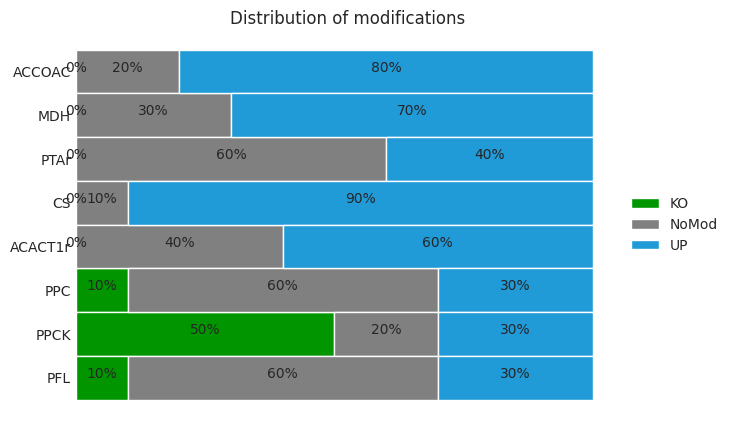

In [32]:
plot_distribution_of_designs(rec_df.drop(['Line Name', 'pred'], axis=1))

We then use MOMA to calculate flux profiles at each time point for the recommended strains. Instead of using the solution time series corresponding to the initial model, we use the solution time series corresponding to the higher production. The reason is that, otherwise, we would never see an increase in isoprenol production, since MOMA minimizes the changes in flux by design. Remember that our goal here is just to create realistic flux profiles that can be used to showcase our straindesignXAI. This approach is good enough for that purpose:

In [7]:
%%time
solutionsMOMA_TS = {}
cols = rec_df.columns[:-1]

if user_params['numinstances'] not in [None, 0]:
    num_strains = user_params['numinstances']
else:
    num_strains = rec_df.shape[0]

for i in tqdm(range(num_strains)):
    design = rec_df[cols].loc[i]
    if design['Line Name']=='WT':
        solutionsMOMA_TS[i] = omg.getBEFluxes(model_TS, design, solution_TS, grid)
    else:
        solutionsMOMA_TS[i] = omg.getBEFluxes(model_TS, design, solutionHI_TS, grid)

 90%|█████████ | 9/10 [23:57<02:40, 160.74s/it]/home/WUR/g0012069/env/main/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/home/WUR/g0012069/env/main/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/home/WUR/g0012069/env/main/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/home/WUR/g0012069/env/main/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/home/WUR/g0012069/env/main/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/home/WUR/g0012069/env/main/lib/python3.10/site-packa

CPU times: user 26min 30s, sys: 5.24 s, total: 26min 35s
Wall time: 26min 37s


### 4. Producing the external metabolite concentrations for each recommendation

In [8]:
cellsEmetsBE = {}
for i in range(num_strains):
    cell, Emets = omg.integrate_fluxes(solutionsMOMA_TS[i], model_TS, user_params['ext_metabolites'], grid, user_params)
    cellsEmetsBE[i] = (cell, Emets) 



We can visualize the obtained concentrations for a recommendation:


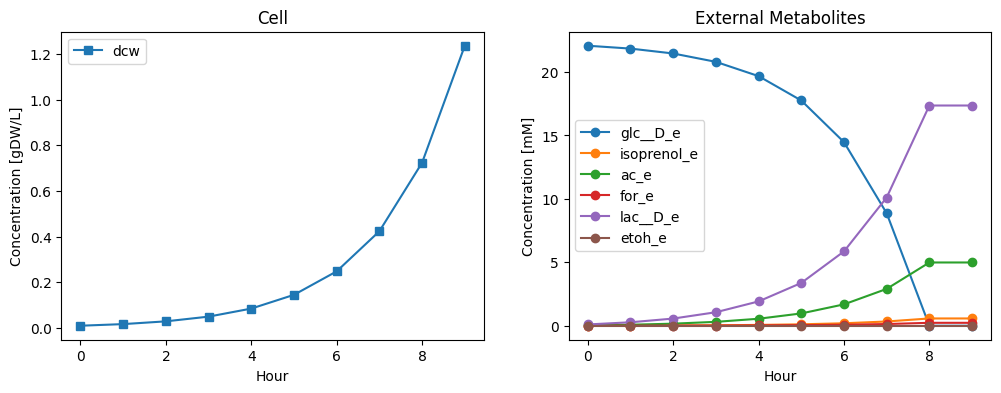

In [13]:
i = 6
cellBE, EmetsBE = cellsEmetsBE[i]
plot_DO_extmets(cellBE, EmetsBE[['glc__D_e','isoprenol_e','ac_e','for_e','lac__D_e','etoh_e']])

In [15]:
EmetsBE

,glc__D_e,nh4_e,pi_e,so4_e,mg2_e,k_e,na1_e,cl_e,isoprenol_e,ac_e,for_e,lac__D_e,etoh_e
0.0,22.07075,18.618548,69.447172,1.998215,1.999939,21.881618,103.7,27.249963,0.003306,0.028783,0.001322,0.100218,0.0
1.0,21.84489,18.48798,69.435511,1.995166,1.999834,21.879259,103.7,27.2499,0.008953,0.07794,0.003581,0.271374,0.0
2.0,21.459157,18.264993,69.415596,1.989959,1.999655,21.875229,103.7,27.249793,0.018596,0.161892,0.007438,0.563679,0.0
3.0,20.800389,17.884166,69.381584,1.981066,1.999349,21.868347,103.7,27.249609,0.035065,0.305267,0.014026,1.062889,0.0
4.0,19.675322,17.233778,69.323497,1.965879,1.998826,21.856593,103.7,27.249296,0.063192,0.550129,0.025277,1.915457,0.0
5.0,17.753893,16.123021,69.224294,1.939942,1.997934,21.836519,103.7,27.248761,0.111228,0.968313,0.044491,3.371503,0.0
6.0,14.472409,14.226031,69.054873,1.895645,1.996411,21.802237,103.7,27.247846,0.193265,1.682503,0.077306,5.85819,0.0
7.0,8.868174,10.986286,68.765528,1.819994,1.993809,21.743688,103.7,27.246285,0.333371,2.902221,0.133348,10.105041,0.0
8.0,0.0,5.453334,68.271375,1.690794,1.989365,21.643696,103.7,27.243619,0.572648,4.985298,0.229059,17.357964,0.0
9.0,0.0,5.453334,68.271375,1.690794,1.989365,21.643696,103.7,27.243619,0.572648,4.985298,0.229059,17.357964,0.0


### Visualizing actual vs predicted isoprenol concentrations for recommendations


In [18]:
production = []
for i in range(user_params['numinstances']):
    cell, Emets = cellsEmetsBE[i]
    production.append(Emets.loc[9,'isoprenol_e'])
    
production_df = rec_df.copy()
production_df['Actual Isoprenol [mM]'] = production.copy()
production_df.sort_values(by='Actual Isoprenol [mM]', ascending=False, inplace=True)
production_df

,Line Name,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,pred,Actual Isoprenol [mM]
6,Strain 7,1,2,1,2,2,1,1,1,0.582319,0.572648
0,Strain 1,2,2,1,2,2,1,2,2,0.589775,0.572648
1,Strain 2,2,1,1,2,2,2,0,1,0.589198,0.572648
3,Strain 4,1,2,2,2,1,1,0,1,0.587963,0.572648
7,Strain 8,2,2,1,2,1,2,0,1,0.580750,0.572648
2,Strain 3,2,1,1,2,2,2,1,1,0.588675,0.572648
4,Strain 5,2,2,2,2,2,1,0,1,0.586856,0.572648
8,Strain 9,2,2,2,2,2,1,2,2,0.580265,0.572648
5,Strain 6,2,2,2,2,1,1,0,2,0.584307,0.572648
9,Strain 10,2,1,1,1,1,0,2,0,1.000000,0.000000


In [19]:
# Save the results
production_df.to_csv('../data/recommendations_with_production.csv')

### Generate omics data for the best recommendation

In [20]:
proteomics_timeseries = {}
transcriptomics_timeseries = {}
metabolomics_timeseries = {}
metabolomics_oldids_timeseries = {}
fluxomics_timeseries = {}
        
for t in tspan:
    fluxomics_timeseries[t] = solutionsMOMA_TS[0][t].fluxes.to_dict()
    (proteomics_timeseries[t], transcriptomics_timeseries[t], 
     metabolomics_timeseries[t], metabolomics_oldids_timeseries[t]) = omg.get_multiomics(model, 
                                                                                         solutionsMOMA_TS[0][t], 
                                                                                         user_params['mapping_file'], 
                                                                                         old_ids=True)

In [73]:
omg.write_experiment_description_file(user_params['edd_omics_file_path'], line_name='Best Strain', label='_BT')
omg.write_OD_data(cell, user_params['edd_omics_file_path'], line_name='Best Strain', label='_BT')
omg.write_external_metabolite(Emets, user_params['edd_omics_file_path'], line_name='Best Strain', label='_BT')

omg.write_omics_files(fluxomics_timeseries, 'fluxomics', user_params, line_name='Best Strain', label='_BT')
omg.write_omics_files(proteomics_timeseries, 'proteomics', user_params, line_name='Best Strain', label='_BT')
omg.write_omics_files(transcriptomics_timeseries, 'transcriptomics', user_params, line_name='Best Strain', label='_BT')
omg.write_omics_files(metabolomics_timeseries, 'metabolomics', user_params, line_name='Best Strain', label='_BT')

genesSM       = ['b0180','b2708','b3197','b1094','b2224','b3256','b2316','b3255','b0185','b1101'] 
proteinsSM    = ['P17115','P45395','P0A6A8','P76461','P77580','P24182','P0A9Q5','P0ABD5','P77580','P00893']
metabolitesSM = ['CID:1549101','CID:175','CID:164533','CID:15938965','CID:21604863','CID:15939608','CID:27284','CID:1038','CID:16741146','CID:1778309']
transcriptomics_timeseriesSM ={}
proteomics_timeseriesSM      ={}
metabolomics_timeseriesSM    ={}
for t in tspan:
    transcriptomics_timeseriesSM[t] = {gene:    transcriptomics_timeseries[t][gene] for gene    in genesSM}
    proteomics_timeseriesSM[t]      = {protein: proteomics_timeseries[t][protein]   for protein in proteinsSM}
    metabolomics_timeseriesSM[t]    = {metab:   metabolomics_timeseries[t][metab]   for metab   in metabolitesSM}

omg.write_omics_files(proteomics_timeseriesSM,     'proteomics'     , user_params, line_name='Best Strain', label='_BTSM')
omg.write_omics_files(transcriptomics_timeseriesSM,'transcriptomics', user_params, line_name='Best Strain', label='_BTSM')
omg.write_omics_files(metabolomics_timeseriesSM,   'metabolomics'   , user_params, line_name='Best Strain', label='_BTSM')
    

/home/WUR/g0012069/straindesignXAI/notebooks/../src/omg.py:481: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, series in dataframe.iteritems():
/home/WUR/g0012069/straindesignXAI/notebooks/../src/omg.py:482: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for id, value in series.iteritems():
/home/WUR/g0012069/straindesignXAI/notebooks/../src/omg.py:481: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, series in dataframe.iteritems():
/home/WUR/g0012069/straindesignXAI/notebooks/../src/omg.py:482: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for id, value in series.iteritems():
/home/WUR/g0012069/straindesignXAI/notebooks/../src/omg.py:481: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for inde

In [80]:
pd.DataFrame(fluxomics_timeseries).T

,EX_cm_e,EX_cmp_e,EX_co2_e,EX_cobalt2_e,DM_4crsol_c,DM_5drib_c,DM_aacald_c,DM_amob_c,DM_mththf_c,EX_colipa_e,...,HMGCOAS,HMGCOAR,MEVK1,DPMVD,IPDPP,PMD,IPMPP,IPtrpp,IPtex,EX_isoprenol_e
0.0,0.0,0.0,9.593168,-0.000013,0.000119,0.00012,0.0,0.000001,0.00024,0.0,...,0.0,0.0,0.0,0.0,0.25,0.0,0.0,-0.25,-0.25,0.25
1.0,0.0,0.0,9.593168,-0.000013,0.000119,0.00012,0.0,0.000001,0.00024,0.0,...,0.0,0.0,0.0,0.0,0.25,0.0,0.0,-0.25,-0.25,0.25
2.0,0.0,0.0,9.593168,-0.000013,0.000119,0.00012,0.0,0.000001,0.00024,0.0,...,0.0,0.0,0.0,0.0,0.25,0.0,0.0,-0.25,-0.25,0.25
3.0,0.0,0.0,9.593168,-0.000013,0.000119,0.00012,0.0,0.000001,0.00024,0.0,...,0.0,0.0,0.0,0.0,0.25,0.0,0.0,-0.25,-0.25,0.25
4.0,0.0,0.0,9.593168,-0.000013,0.000119,0.00012,0.0,0.000001,0.00024,0.0,...,0.0,0.0,0.0,0.0,0.25,0.0,0.0,-0.25,-0.25,0.25
5.0,0.0,0.0,9.593168,-0.000013,0.000119,0.00012,0.0,0.000001,0.00024,0.0,...,0.0,0.0,0.0,0.0,0.25,0.0,0.0,-0.25,-0.25,0.25
6.0,0.0,0.0,9.593168,-0.000013,0.000119,0.00012,0.0,0.000001,0.00024,0.0,...,0.0,0.0,0.0,0.0,0.25,0.0,0.0,-0.25,-0.25,0.25
7.0,0.0,0.0,9.593168,-0.000013,0.000119,0.00012,0.0,0.000001,0.00024,0.0,...,0.0,0.0,0.0,0.0,0.25,0.0,0.0,-0.25,-0.25,0.25
8.0,0.0,0.0,9.593168,-0.000013,0.000119,0.00012,0.0,0.000001,0.00024,0.0,...,0.0,0.0,0.0,0.0,0.25,0.0,0.0,-0.25,-0.25,0.25
